<a href="https://colab.research.google.com/github/rmahesh6386/DataScience_Python/blob/main/Reliance_Stock_Market_Forecasting_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score
import math
import numpy as np
import yfinance as yf

In [10]:
tickers=["RELIANCE.NS"]
data =yf.download(tickers)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,15.859429,15.944529,15.754989,15.917452,10.509537,48051995
1996-01-02,15.878770,15.956133,15.677626,15.793671,10.427810,77875009
1996-01-03,16.052837,16.783918,15.878770,15.913584,10.506983,96602936
1996-01-04,15.762726,15.813012,15.553845,15.766594,10.409932,100099436
1996-01-05,15.704703,15.704703,15.522900,15.658285,10.338423,76935930
...,...,...,...,...,...,...
2022-07-13,2427.300049,2434.000000,2373.000000,2377.550049,2377.550049,6564435
2022-07-14,2388.000000,2433.949951,2376.949951,2397.149902,2397.149902,7831798
2022-07-15,2415.000000,2415.000000,2383.100098,2401.800049,2401.800049,4431880


In [11]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,15.859429,15.944529,15.754989,15.917452,10.509537,48051995
1996-01-02,15.878770,15.956133,15.677626,15.793671,10.427810,77875009
1996-01-03,16.052837,16.783918,15.878770,15.913584,10.506983,96602936
1996-01-04,15.762726,15.813012,15.553845,15.766594,10.409932,100099436
1996-01-05,15.704703,15.704703,15.522900,15.658285,10.338423,76935930


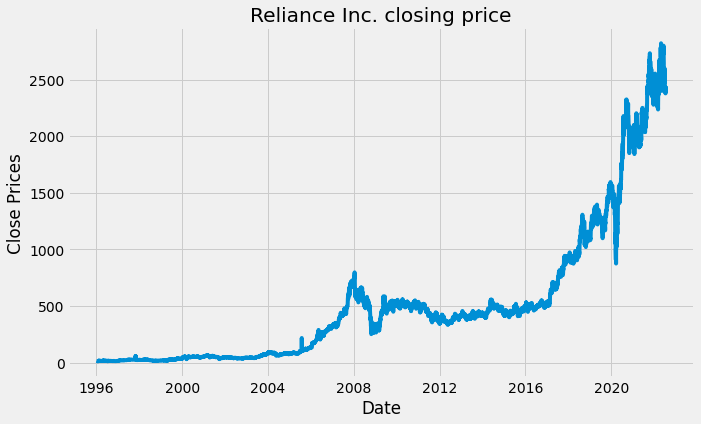

In [12]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Reliance Inc. closing price')
plt.show()

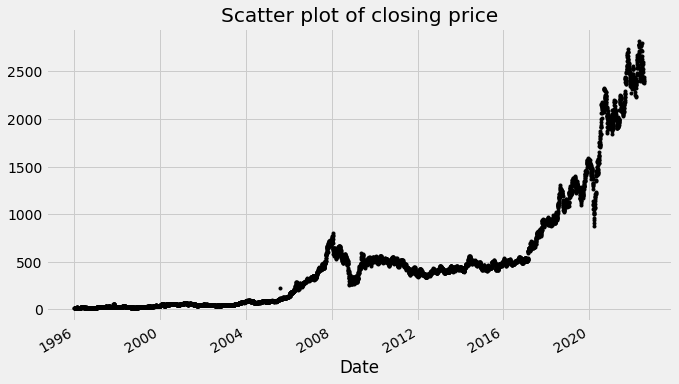

In [13]:
 #scatterplot:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

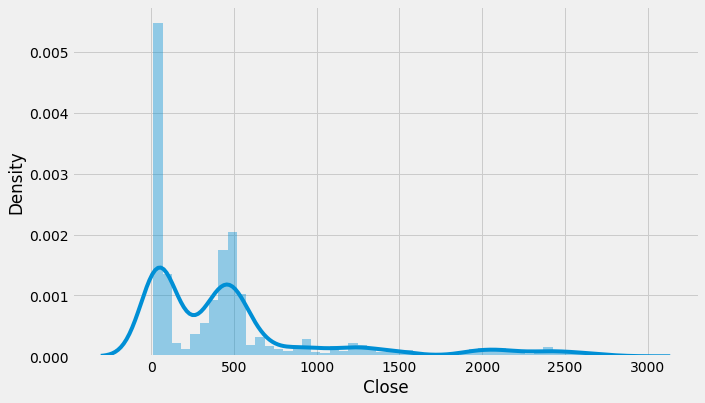

In [14]:
import seaborn as sns
sns.distplot(data['Close'])

### checking for stationarity:

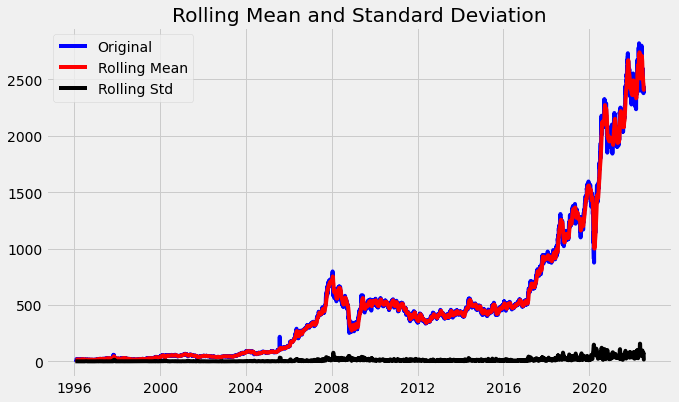

Results of dickey fuller test
Test Statistics                   1.273795
p-value                           0.996458
No. of lags used                 31.000000
Number of observations used    6646.000000
critical value (1%)              -3.431334
critical value (5%)              -2.861975
critical value (10%)             -2.567002
dtype: float64


In [15]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

##### We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

     In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

###  Separate Trend and Seasonality from the time series

<Figure size 720x432 with 0 Axes>

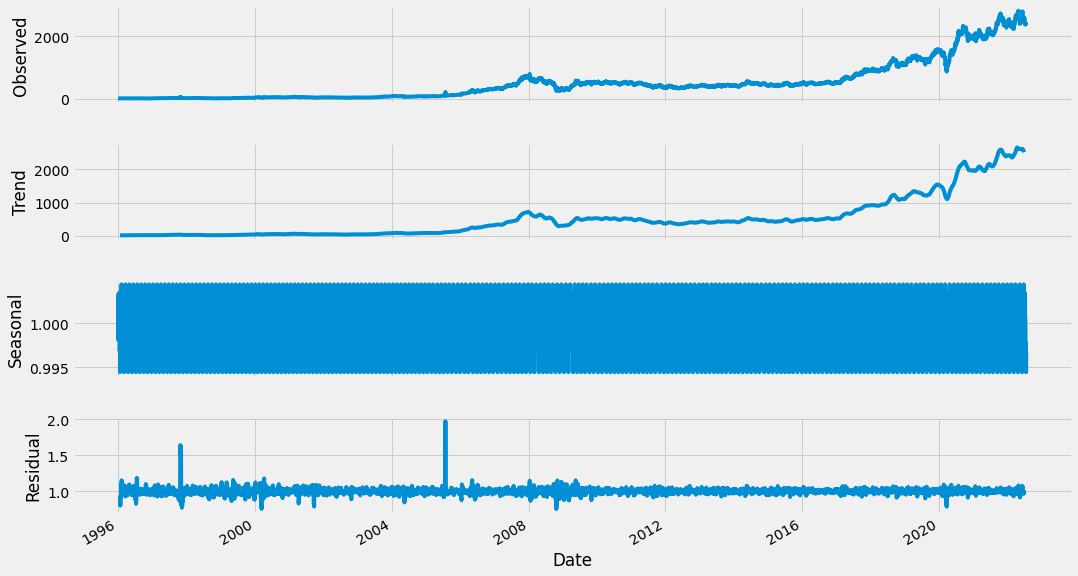

In [16]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


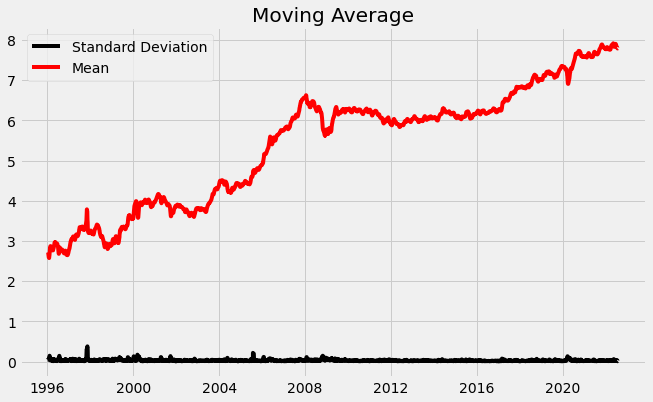

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

## Creating  an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it

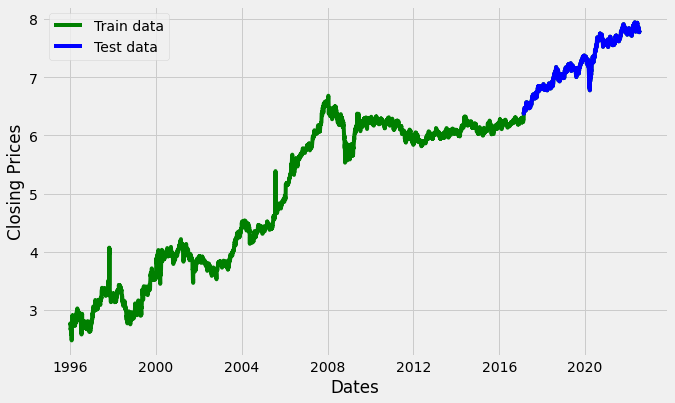

In [18]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

### Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

##### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
    The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.
    
    
    The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [19]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22338.674, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22367.149, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22367.974, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22338.051, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22366.801, Time=1.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-22366.626, Time=1.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22371.070, Time=3.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-22367.904, Time=6.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-22363.080, Time=4.82 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-22365.096, Time=1.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-22368.370, Time=3.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-22361.065, Time=7.67 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-22369.013, Time=1.38 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 34.342 sec

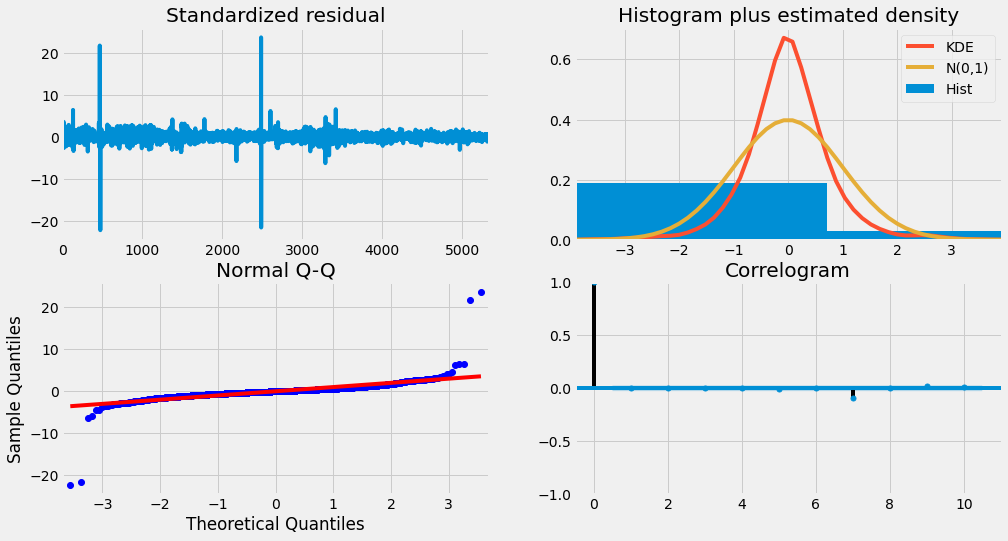

In [20]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [21]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5338
Model:                 ARIMA(0, 1, 0)   Log Likelihood               11171.337
Method:                           css   S.D. of innovations              0.030
Date:                Tue, 19 Jul 2022   AIC                         -22338.674
Time:                        09:15:27   BIC                         -22325.509
Sample:                             1   HQIC                        -22334.075
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.620      0.105      -0.000       0.001


### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

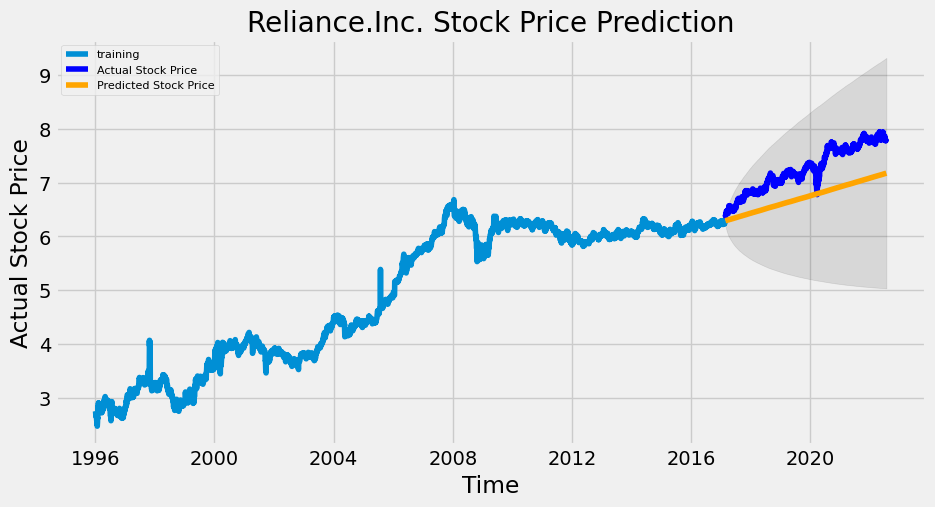

In [22]:
# Forecast
fc, se, conf = fitted.forecast(1336, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Reliance.Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### As you can see our model did quite handsomely. Let us also check the commonly used accuracy metrics to judge forecast results:

In [23]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data,fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 0.30728688767851253
MAE: 0.523860772498228
RMSE: 0.5543346351063702
MAPE: 0.07106343485652848
